# Climate data


## Historical data

This is the preprocessing af the data from https://climateknowledgeportal.worldbank.org/download-data

There is an issues when attemption to download this data, selecting all countries and choosing the 1901-2016 time periods results in 'error 504 bad gateway timeout'. However, the preprocessing should be the same for any country and time period considering that the data source is the same. After making a smaller selection it was possible to download the data but only for 93 countries.

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("tas_1901_2016_AFG_CH.csv", sep = ',', header = 0, usecols = range(0,5))

df.dtypes

Temperature - (Celsius)    float64
 Year                        int64
 Statistics                 object
 Country                    object
 ISO3                       object
dtype: object

In [2]:
df.head(5)

,Temperature - (Celsius),Year,Statistics,Country,ISO3
0,-0.03780,1901,Jan Average,Afghanistan,AFG
1,2.42348,1901,Feb Average,Afghanistan,AFG
2,9.36230,1901,Mar Average,Afghanistan,AFG
3,13.55640,1901,Apr Average,Afghanistan,AFG
4,18.15090,1901,May Average,Afghanistan,AFG


## Pre-processing

Things to do:
- rename the columns
- make seperate list will all the country codes
- make separate list with all the years
- strip value of leading white spaces

In [3]:
df.rename({df.columns[0]: "Temperature", df.columns[1]: "Year", df.columns[2]: "Month", df.columns[3]: "Country", df.columns[4]: "Code"}, axis = 1, inplace = True)

df['Code'] = df['Code'].str.strip()
df['Country'] = df['Country'].str.strip()

df.dtypes

Temperature    float64
Year             int64
Month           object
Country         object
Code            object
dtype: object

In [4]:
name = df.Month.unique()
number = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for i in range(0,12):
    df = df.replace(name[i], number[i])

country_codes = np.asarray(pd.unique(df.Code))
years = np.asarray(pd.unique(df.Year))

We can now turn all these operations into some sort of pipeline by defining a function that will do all of this in one go.

In [5]:
def preprocess_historical_temp(file_name, names_years = True):
    """Imports and pre-processes the historical temperatures"""
    
    df = pd.read_csv(file_name, sep = ',', header = 0, usecols = range(0,5))
    df.rename({df.columns[0]: "Temperature", df.columns[1]: "Year", df.columns[2]: "Month", df.columns[3]: "Country", df.columns[4]: "Code"}, axis = 1, inplace = True)

    df['Code'] = df['Code'].str.strip()
    df['Country'] = df['Country'].str.strip()
    
    name = df.Month.unique()
    number = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    for i in range(0,12):
        df = df.replace(name[i], number[i])
    
    if names_years is False:    
        return df
    
    country_codes = np.asarray(pd.unique(df.Code))
    years = np.asarray(pd.unique(df.Year))
    
    return clean_data, country_codes, years

We should check whether, or how many, missing values there are.

In [28]:
df.isna().sum()

Temperature    0
Year           0
Month          0
Country        0
Code           0
dtype: int64

There are no missing values.

## Yearly averages

The data provides the average temperature for each month of the year. It is likely that having the average yearly temperture will be more useful. We can create a second dataset that includes the yearly averages.

NOTE: Function already modified so that it will work with the predicted temperature data. (That's what the *model if statements* are for.)

In [49]:
def get_yearly_averages(df):
    """Gets the average yearly temperature for each country"""
    yearly_av = []
    
    country_codes = np.asarray(pd.unique(df.Code))
    years = np.asarray(pd.unique(df.Year))
    weights = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    if 'Model' in df.columns:
        models = np.asarray(pd.unique(df.Model))
        
    for country in country_codes:
        temp1 = df.loc[df['Code'] == country]
        for year in years:            
            if 'Model' in df.columns:
                for model in models:
                    temp2 = temp1.loc[temp1['Model'] == model]
                    w_map = temp2['Month'].map(weights)
                    total = w_map*temp2['Temperature']
                    answer = total.sum()/365
                    yearly_av.append([country, year, np.round(answer, 3), model])
            else:
                temp2 = temp1.loc[temp1['Year'] == year]
                w_map = temp2['Month'].map(weights)
                total = w_map*temp2['Temperature']
                answer = total.sum()/365
                yearly_av.append([country, year, np.round(answer, 3)])
    
    df_yearly = np.asarray(yearly_av)
    
    if 'Model' in df.columns:
        df_yearly = pd.DataFrame(df_yearly, columns = ['Code', 'Year', 'Average Temp', 'Model'])
    else:
        df_yearly = pd.DataFrame(df_yearly, columns = ['Code', 'Year', 'Average Temp'])
    
    if 'Model' in df.columns:
        df_yearly = df_yearly.astype({'Average Temp':'float64'})
    else:
        df_yearly = df_yearly.astype({'Year':'int64', 'Average Temp':'float64'})
    
    return df_yearly

In [53]:
df_yearly = get_yearly_averages(df)

df_yearly.head(10)

,Code,Year,Average Temp
0,AFG,1901,13.231
1,AFG,1902,13.407
2,AFG,1903,12.051
3,AFG,1904,12.567
4,AFG,1905,12.344
5,AFG,1906,12.902
6,AFG,1907,12.195
7,AFG,1908,12.573
8,AFG,1909,13.094
9,AFG,1910,12.420


In [8]:
df_yearly['Code'].nunique()

79

We are missing countries due to the download issue mentioned previously.

In [9]:
for i in range(len(pd.unique(df['Code']))):
    print(pd.unique(df['Country'])[i])
    print(pd.unique(df['Code'])[i])

Afghanistan
AFG
Albania
ALB
Algeria
DZA
Andorra
AND
Angola
AGO
Antigua and Barbuda
ATG
Argentina
ARG
Armenia
ARM
Australia
AUS
Austria
AUT
Azerbaijan
AZE
Bahamas
BHS
Bahrain
BHR
Bangladesh
BGD
Barbados
BRB
Belarus
BLR
Belgium
BEL
Belize
BLZ
Benin
BEN
Bhutan
BTN
Bolivia
BOL
Bosnia and Herzegovina
BIH
Botswana
BWA
Brazil
BRA
Brunei
BRN
Bulgaria
BGR
Burkina Faso
BFA
Burundi
BDI
Cambodia
KHM
Cameroon
CMR
Canada
CAN
Cape Verde
CPV
Central African Republic
CAF
Chad
TCD
Chile
CHL
China
CHN
Colombia
COL
Comoros
COM
Congo (Democratic Republic of the)
COD
Congo (Republic of the)
COG
Costa Rica
CRI
Cote d'Ivoire
CIV
Croatia
HRV
Cuba
CUB
Cyprus
CYP
Czech Republic
CZE
Denmark
DNK
Djibouti
DJI
Dominica
DMA
Dominican Republic
DOM
Ecuador
ECU
Egypt
EGY
El Salvador
SLV
Equatorial Guinea
GNQ
Eritrea
ERI
Estonia
EST
Ethiopia
ETH
Faroe Islands
FRO
Federated States of Micronesia
FSM
Fiji
FJI
Finland
FIN
France
FRA
Gabon
GAB
Gambia
The
Georgia
GEO
Germany
DEU
Ghana
GHA
Greece
GRC
Greenland
GRL
Grenada
GRD
G

## Simple plotting

Now that we have clean datasets we can do some simple plotting to familiarise ourselves with the data. 

### Yearly averages

We can start by producing plots for the average yearly temperature for a selected country.

In [10]:
choice = widgets.Dropdown(
    options=country_codes,
    value=country_codes[0],
    description='Country:',
    disabled=False,
)

choice

Dropdown(description='Country:', options=('AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS', 'AUT'…

<AxesSubplot:title={'center':'AUS'}, xlabel='Year'>

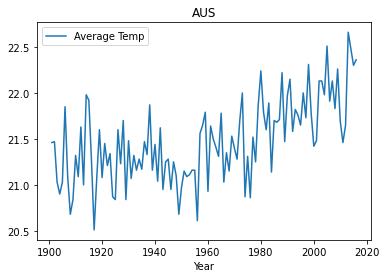

In [11]:
df_plot = df_yearly.loc[df_yearly['Code'] == choice.value]
df_plot.plot(x = 'Year', y = 'Average Temp', title = choice.value)

In [12]:
df_yearly.dtypes

Code             object
Year              int64
Average Temp    float64
dtype: object

# Climate data cont.

## Projected climate data

Preprocessing data from https://climateknowledgeportal.worldbank.org/download-data

It was possible to select all countries at once, no gateway timeout error. Need to double check that all countries did inded download or whether it cut them off at some point.

### Import raw data

First we'll import the raw data to investigate its structure so tat we can then define what preprocessing steps are necessary.

In [13]:
proj = pd.read_csv("tas_2020_2039_mavg_rcp26_AFG_CAF.csv", sep = ',', header = 0, usecols = range(0,6))

proj.head(10)

,Monthly Temperature - (Celsius),Year,Model,Statistics,Country,ISO3
0,-0.722797,2020-2039,bcc_csm1_1,Jan Average,Afghanistan,AFG
1,1.788925,2020-2039,bcc_csm1_1,Feb Average,Afghanistan,AFG
2,6.647932,2020-2039,bcc_csm1_1,Mar Average,Afghanistan,AFG
3,13.529653,2020-2039,bcc_csm1_1,Apr Average,Afghanistan,AFG
4,18.811602,2020-2039,bcc_csm1_1,May Average,Afghanistan,AFG
5,25.430595,2020-2039,bcc_csm1_1,Jun Average,Afghanistan,AFG
6,28.008215,2020-2039,bcc_csm1_1,Jul Average,Afghanistan,AFG
7,26.263004,2020-2039,bcc_csm1_1,Aug Average,Afghanistan,AFG
8,21.933239,2020-2039,bcc_csm1_1,Sep Average,Afghanistan,AFG
9,14.529192,2020-2039,bcc_csm1_1,Oct Average,Afghanistan,AFG


In [14]:
proj.dtypes

Monthly Temperature - (Celsius)    float64
 Year                               object
 Model                              object
 Statistics                         object
 Country                            object
 ISO3                               object
dtype: object

This dataset has a similar structure to the historical dataset, although some differences do exist:
- no individual years but rather one prediciton for the whole interval
- added column for the prediciton model specification

The preprocessing will therefore be similar with some minor adjustments.

In [15]:
def preprocess_forecast_temp(file_name):
    """Imports and pre-processes the historical temperatures"""
    
    df = pd.read_csv(file_name, sep = ',', header = 0, usecols = range(0,6))
    df.rename({df.columns[0]: "Temperature", df.columns[1]: "Year", df.columns[2]: "Model", df.columns[3]: "Month", df.columns[4]: "Country", df.columns[5]: "Code"}, axis = 1, inplace = True)

    df['Code'] = df['Code'].str.strip()
    df['Country'] = df['Country'].str.strip()
    
    name = df.Month.unique()
    number = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    for i in range(0,12):
        df = df.replace(name[i], number[i])
    
    return df

In [16]:
proj = preprocess_forecast_temp("tas_2020_2039_mavg_rcp26_AFG_CAF.csv")

proj.head(10)

,Temperature,Year,Model,Month,Country,Code
0,-0.722797,2020-2039,bcc_csm1_1,1,Afghanistan,AFG
1,1.788925,2020-2039,bcc_csm1_1,2,Afghanistan,AFG
2,6.647932,2020-2039,bcc_csm1_1,3,Afghanistan,AFG
3,13.529653,2020-2039,bcc_csm1_1,4,Afghanistan,AFG
4,18.811602,2020-2039,bcc_csm1_1,5,Afghanistan,AFG
5,25.430595,2020-2039,bcc_csm1_1,6,Afghanistan,AFG
6,28.008215,2020-2039,bcc_csm1_1,7,Afghanistan,AFG
7,26.263004,2020-2039,bcc_csm1_1,8,Afghanistan,AFG
8,21.933239,2020-2039,bcc_csm1_1,9,Afghanistan,AFG
9,14.529192,2020-2039,bcc_csm1_1,10,Afghanistan,AFG


**PROBLEM ALERT** - (also applies to the historical dataset.)

We can see that there are some issues with the data as not every country has its country code correctly processed. The following have issues:
- All countries following Gambia have their country codes shifted to the previous country. (e.g. Georgia has DEU, Germany has GHA). THis is up unitl the problem with the Koreas.
- Kiribati (KIR) has as countyry code 'Democratic People's Republic of'
- Democratic People's Republic of Korea (PRK) is omitted
- South Korea (KOR) has as its country code 'Republic of'
- Tanzania (TZA) has as its country code 'United Republic of'

These problems are shown below by printing each country's name and its associated country code.

In [38]:
for i in range(len(pd.unique(proj['Code']))):
    print('Country -', pd.unique(proj['Country'])[i], '- has code -', pd.unique(proj['Code'])[i])

Country - Afghanistan - has code -  AFG
Country - Albania - has code -  ALB
Country - Algeria - has code -  DZA
Country - Andorra - has code -  AND
Country - Angola - has code -  AGO
Country - Antigua and Barbuda - has code -  ATG
Country - Argentina - has code -  ARG
Country - Armenia - has code -  ARM
Country - Australia - has code -  AUS
Country - Austria - has code -  AUT
Country - Azerbaijan - has code -  AZE
Country - Bahamas - has code -  The
Country - Bahrain - has code -  BHR
Country - Bangladesh - has code -  BGD
Country - Barbados - has code -  BRB
Country - Belarus - has code -  BLR
Country - Belgium - has code -  BEL
Country - Belize - has code -  BLZ
Country - Benin - has code -  BEN
Country - Bhutan - has code -  BTN
Country - Bolivia - has code -  BOL
Country - Bosnia and Herzegovina - has code -  BIH
Country - Botswana - has code -  BWA
Country - Brazil - has code -  BRA
Country - Brunei - has code -  BRN
Country - Bulgaria - has code -  BGR
Country - Burkina Faso - ha

If one looks at the original file it is possible to see that there are some formatting problems. There are commas where there shouldn't be commas. (Technically they should be there since the comma is a part of country name, BUT this really messes with the formatting of a **Comma Seperated Values** file so they really should have thought of that and done something about it).

We can fix this using the following script. It fixes all these problematic names and replces them with ones that make sense. This fixed version is then saved to a new **.csv** file.

Same bit of code can be used to fix this same issue on the historical dataset.

In [17]:
data = ""

with open("tas_2020_2039_mavg_rcp26_AFG_CAF.csv", 'r') as file:
     data = file.read().replace("Gambia, The", "Gambia").replace("Korea, Democratic People's Republic of", "North Korea").replace("Korea, Republic of", "South Korea").replace("Tanzania, United Republic of", "Tanzania").replace("Bahamas, The", "Bahamas")

with open("proj_2020_2039_rcp26.csv", 'w') as file:
     file.write(data)

Now that we have a new file without those problems we can import the dataset again but using this clean file.

We can then check whether the country names and codes are now problem free.

In [78]:
proj = preprocess_forecast_temp("proj_2020_2039_rcp26.csv")

for i in range(len(pd.unique(proj['Code']))):
    print('Country -', pd.unique(proj['Country'])[i], '- has code -', pd.unique(proj['Code'])[i])

Country - Afghanistan - has code - AFG
Country - Albania - has code - ALB
Country - Algeria - has code - DZA
Country - Andorra - has code - AND
Country - Angola - has code - AGO
Country - Antigua and Barbuda - has code - ATG
Country - Argentina - has code - ARG
Country - Armenia - has code - ARM
Country - Australia - has code - AUS
Country - Austria - has code - AUT
Country - Azerbaijan - has code - AZE
Country - Bahamas - has code - BHS
Country - Bahrain - has code - BHR
Country - Bangladesh - has code - BGD
Country - Barbados - has code - BRB
Country - Belarus - has code - BLR
Country - Belgium - has code - BEL
Country - Belize - has code - BLZ
Country - Benin - has code - BEN
Country - Bhutan - has code - BTN
Country - Bolivia - has code - BOL
Country - Bosnia and Herzegovina - has code - BIH
Country - Botswana - has code - BWA
Country - Brazil - has code - BRA
Country - Brunei - has code - BRN
Country - Bulgaria - has code - BGR
Country - Burkina Faso - has code - BFA
Country - Bur

The data is now problem free. The country names and country codes are all correct.

In [18]:
proj.head(10)

,Temperature,Year,Model,Month,Country,Code
0,-0.722797,2020-2039,bcc_csm1_1,1,Afghanistan,AFG
1,1.788925,2020-2039,bcc_csm1_1,2,Afghanistan,AFG
2,6.647932,2020-2039,bcc_csm1_1,3,Afghanistan,AFG
3,13.529653,2020-2039,bcc_csm1_1,4,Afghanistan,AFG
4,18.811602,2020-2039,bcc_csm1_1,5,Afghanistan,AFG
5,25.430595,2020-2039,bcc_csm1_1,6,Afghanistan,AFG
6,28.008215,2020-2039,bcc_csm1_1,7,Afghanistan,AFG
7,26.263004,2020-2039,bcc_csm1_1,8,Afghanistan,AFG
8,21.933239,2020-2039,bcc_csm1_1,9,Afghanistan,AFG
9,14.529192,2020-2039,bcc_csm1_1,10,Afghanistan,AFG


We should check whether there are any missing values. We can see that there aren't any, as one would expect considering that the dataset is based on a projection and not historical data.

In [20]:
proj.isna().sum()

Temperature    0
Year           0
Model          0
Month          0
Country        0
Code           0
dtype: int64

## Yearly Averages

Again we can calculate the yearly averages. We modified the function so that it will work with this dataset already, so we just need to call it.

The modifications revolve around the fact that there is only on single year option for the predicted values, but there are multiple different models to choose from.

In [21]:
proj_yearly = get_yearly_averages(proj)

proj_yearly.head(10)

,Code,Year,Average Temp,Model
0,AFG,2020-2039,13.64,bcc_csm1_1
1,AFG,2020-2039,14.19,bcc_csm1_1_m
2,AFG,2020-2039,14.28,ccsm4
3,AFG,2020-2039,14.96,cesm1_cam5
4,AFG,2020-2039,12.87,csiro_mk3_6_0
5,AFG,2020-2039,14.96,fio_esm
6,AFG,2020-2039,13.10,gfdl_cm3
7,AFG,2020-2039,13.86,gfdl_esm2m
8,AFG,2020-2039,14.11,giss_e2_h
9,AFG,2020-2039,13.58,giss_e2_r


## Plotting

Since we only have one value for the whole decade, it doesn't make sense to plot a time series of the yearly projection. We could plot the values for the different models to see whether different, and if so, for which countries they differ the most between each other.

In [22]:
country_choice = widgets.Dropdown(
    options=pd.unique(proj['Code']),
    value=pd.unique(proj['Code'])[0],
    description='Country:',
    disabled=False,
)

country_choice

Dropdown(description='Country:', options=('AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS', 'AUT'…

<AxesSubplot:title={'center':'AUS'}, xlabel='Model'>

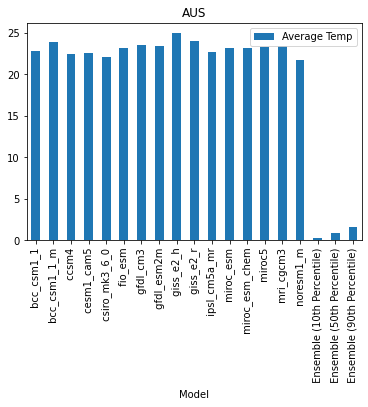

In [24]:
proj_yearly_plot = proj_yearly.loc[proj_yearly['Code'] == country_choice.value]
proj_yearly_plot.plot.bar(x = 'Model', y = 'Average Temp', title = country_choice.value)

We can see that the different models has different values for the projected average yearly temperature.

We can also visualise how the projections differ on a monthly scale.

In [25]:
month_choice = widgets.Dropdown(
    options=pd.unique(proj['Month']),
    value=pd.unique(proj['Month'])[0],
    description='Month:',
    disabled=False,
)

month_choice

Dropdown(description='Month:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1)

<AxesSubplot:title={'center':'AUS at month number 12'}, xlabel='Model'>

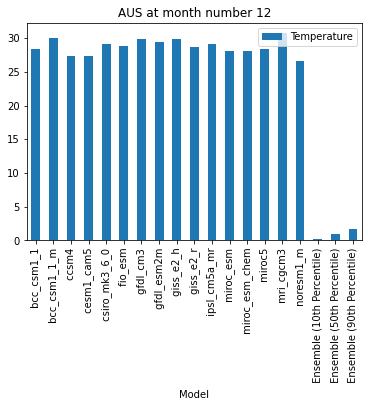

In [26]:
proj_monthly_plot = proj.loc[proj['Code'] == country_choice.value]
proj_monthly_plot = proj_monthly_plot[proj_monthly_plot['Month'] == month_choice.value]
proj_monthly_plot.plot.bar(x = 'Model', y = 'Temperature', title = country_choice.value + " at month number " + str(month_choice.value))

We can see the the pattern in the differences between the models stays the same when looking at the monthly data.